# Gen.jl Sequential Bayesian Inference for Pixelated MNIST
This notebook is a **minimal, runnable skeleton** for the probabilistic inference scheme:

- **Observation model**: pixelated template + Gaussian pixel noise  
- **Sequential evidence accumulation**: posterior over digits updated as pixelation decreases  
- **Stopping rule**: guess when `max posterior ≥ τ` (or use top-2 log-odds)

It also includes an optional **Gen.jl behavioral model** to fit parameters like `(σ, τ)` from human action traces.

## 0) Setup
Activate environment, install dependencies, and import packages.

In [1]:
import Pkg
Pkg.activate(".")
Pkg.add([
    "Gen",
    "Distributions",
    "Statistics",
    "LinearAlgebra",
    "Random",
    "MLDatasets",
    "Images",
    "ImageIO",
    "CSV",
    "DataFrames",
    "Plots"
])

  Activating project at `~/966-project`
   Resolving package versions...
  No Changes to `~/966-project/Project.toml`
  No Changes to `~/966-project/Manifest.toml`


In [79]:
using Gen
using Distributions
using Statistics, LinearAlgebra, Random
using MLDatasets
using Images, ImageIO
using CSV, DataFrames
using Plots

## 1) Preprocessing
Load human annotations and helper utilities for working with the pixelated image directory.

**Important:** data-loading code and file paths are unchanged; this section only reorganizes execution flow.

### 1.2) Identify annotated vs unannotated images

In [80]:
"""Get all image indices that have been annotated by any user."""
function get_annotated_indices(human_data_dir="human_data")
    annotated = Set{Int}()
    
    if !isdir(human_data_dir)
        println("No human_data directory found")
        return annotated
    end
    
    for user_dir in readdir(human_data_dir)
        csv_path = joinpath(human_data_dir, user_dir, "results.csv")
        if isfile(csv_path)
            # Read CSV as strings to avoid type issues, then parse manually
            df = CSV.read(csv_path, DataFrame; types=String, silencewarnings=true)
            for row in eachrow(df)
                img_idx_str = row.image_idx
                # Skip header rows and empty values
                if img_idx_str === nothing || img_idx_str == "" || img_idx_str == "image_idx"
                    continue
                end
                try
                    idx = parse(Int, img_idx_str)
                    push!(annotated, idx)
                catch e
                    # Skip rows that can't be parsed (e.g., header rows)
                    continue
                end
            end
        end
    end
    
    return annotated
end

"""Load image from pixelated_mnist directory."""
function load_pixelated_image(img_idx::Int, pixelation_level::Float64; 
                              pixelated_dir="pixelated_mnist")
    # Find the directory for this image
    pattern = Regex("image_$(lpad(img_idx, 3, "0"))_class_\\d+")
    img_dirs = filter(x -> occursin(pattern, x), readdir(pixelated_dir))
    
    if isempty(img_dirs)
        error("No directory found for image index $img_idx")
    end
    
    img_dir = joinpath(pixelated_dir, img_dirs[1])
    
    # Parse pixelation level to filename format (e.g., 6.5 -> "06.5_pixelate.png", 1.0 -> "01.0_pixelate.png")
    int_part = Int(floor(pixelation_level))
    # Get first decimal digit (e.g., 6.5 -> 5, 1.0 -> 0, 4.2 -> 2)
    dec_part = Int(round((pixelation_level - int_part) * 10))
    filename = "$(lpad(int_part, 2, "0")).$(dec_part)_pixelate.png"
    filepath = joinpath(img_dir, filename)
    
    if !isfile(filepath)
        error("File not found: $filepath (tried level $pixelation_level)")
    end
    
    # Load and convert to Float64 matrix in [0,1]
    img = load(filepath)
    img_gray = Gray.(img)
    img_matrix = Float64.(channelview(img_gray))
    
    return img_matrix
end

"""Get class label for an image from its directory name."""
function get_image_class(img_idx::Int; pixelated_dir="pixelated_mnist")
    pattern = Regex("image_$(lpad(img_idx, 3, "0"))_class_(\\d+)")
    img_dirs = filter(x -> occursin(pattern, x), readdir(pixelated_dir))
    
    if isempty(img_dirs)
        error("No directory found for image index $img_idx")
    end
    
    m = match(pattern, img_dirs[1])
    return parse(Int, m.captures[1])
end

"""Get all available image indices from pixelated_mnist."""
function get_all_pixelated_indices(pixelated_dir="pixelated_mnist")
    indices = Int[]
    pattern = Regex("image_(\\d+)_class_\\d+")
    
    for dirname in readdir(pixelated_dir)
        m = match(pattern, dirname)
        if m !== nothing
            push!(indices, parse(Int, m.captures[1]))
        end
    end
    
    return sort(unique(indices))
end

# Get annotated indices from all users
annotated_indices = get_annotated_indices()
println("Found $(length(annotated_indices)) annotated images across all users")

# Get all available pixelated image indices
all_indices = get_all_pixelated_indices()
println("Found $(length(all_indices)) total images in pixelated_mnist")

# Get unannotated indices (these will be used for template building)
unannotated_indices = setdiff(Set(all_indices), annotated_indices)
println("Using $(length(unannotated_indices)) unannotated images for template building")

Found 400 annotated images across all users
Found 1400 total images in pixelated_mnist
Using 1000 unannotated images for template building


### 1.3) Load human annotation data

In [81]:
"""Load human experiment data from CSV."""
function load_human_data(csv_path)
    # Read CSV as strings to avoid type issues, then parse manually
    df = CSV.read(csv_path, DataFrame; types=String, silencewarnings=true)
    
    # Group by image_idx to get sequences
    episodes = Dict{Int, Dict}()
    
    for row in eachrow(df)
        # Skip header rows or invalid rows
        img_idx_str = row.image_idx
        if img_idx_str === nothing || img_idx_str == "" || img_idx_str == "image_idx"
            continue
        end
        
        try
            # Parse image_idx
            img_idx = parse(Int, img_idx_str)
            
            # Parse class_label
            class_label_str = row.class_label
            if class_label_str === nothing || class_label_str == "" || class_label_str == "class_label"
                continue
            end
            class_label = parse(Int, class_label_str)
            
            # Parse pixelation_level
            pixelation_level_str = row.pixelation_level
            if pixelation_level_str === nothing || pixelation_level_str == "" || pixelation_level_str == "pixelation_level"
                continue
            end
            pixelation_level = parse(Float64, pixelation_level_str)
            
            # Get action (should be a string)
            action = string(row.action_taken)
            user_guess_str = row.user_guess
            
            if !haskey(episodes, img_idx)
                episodes[img_idx] = Dict(
                    :image_idx => img_idx,
                    :class_label => class_label,
                    :levels => Float64[],
                    :actions => String[],
                    :user_guess => missing,
                    :correct => missing
                )
            end
            
            push!(episodes[img_idx][:levels], pixelation_level)
            push!(episodes[img_idx][:actions], action)
            
            # Store guess if present
            if user_guess_str !== nothing && user_guess_str != "" && user_guess_str != "user_guess"
                try
                    guess_val = parse(Int, user_guess_str)
                    episodes[img_idx][:user_guess] = guess_val
                    correct_str = string(row.correct)
                    episodes[img_idx][:correct] = (correct_str == "True" || correct_str == "true")
                catch
                    # Skip if conversion fails
                end
            end
        catch e
            # Skip rows that can't be parsed
            continue
        end
    end
    
    # Sort levels in descending order (most pixelated first) to match experiment flow
    for (idx, ep) in episodes
        # Get unique levels and sort descending
        unique_levels = sort(unique(ep[:levels]), rev=true)
        # Reconstruct action sequence based on level order
        level_to_action = Dict(zip(ep[:levels], ep[:actions]))
        ep[:levels] = unique_levels
        ep[:actions] = [level_to_action[l] for l in unique_levels]
    end
    
    return episodes
end

# Load data from ALL users, treating each (user, image_idx) as unique
human_episodes = Dict{Int, Dict}()
user_dirs = ["Brian", "CJ", "Ethan", "Hutch", "Malachi"]
episode_counter = 0

for user in user_dirs
    human_data_path = "human_data/$user/results.csv"
    if isfile(human_data_path)
        user_episodes = load_human_data(human_data_path)
        println("Loaded $(length(user_episodes)) episodes from $human_data_path")
        
        # Add each episode with a unique key (using counter to ensure uniqueness)
        for (img_idx, ep) in user_episodes
            # Create a unique episode entry
            episode_counter += 1
            human_episodes[episode_counter] = Dict(
                :image_idx => ep[:image_idx],
                :class_label => ep[:class_label],
                :levels => ep[:levels],
                :actions => ep[:actions],
                :user_guess => ep[:user_guess],
                :correct => ep[:correct],
                :user => user  # Store user name for reference
            )
        end
    else
        println("Human data file not found: $human_data_path")
    end
end

println("\nTotal combined episodes: $(length(human_episodes))")
if length(human_episodes) > 0
    first_ep = human_episodes[1]
    println("First episode: image_idx=$(first_ep[:image_idx]), ",
            "class=$(first_ep[:class_label]), ",
            "user=$(first_ep[:user]), ",
            "levels=$(first_ep[:levels])")
end

Loaded 52 episodes from human_data/Ethan/results.csv
First episode (smallest image_idx): image_idx=0, class=0, levels=[6.5, 5.0, 4.2]


## 2) Build templates for each class
Compute per-class mean images (templates) using **unannotated** images only.

In [63]:
function build_templates_by_level(
    exclude_indices::Set{Int},
    levels::Vector{Float64};
    pixelated_dir="pixelated_mnist"
)
    templates_by_level = Dict{Float64, Vector{Matrix{Float64}}}()
    counts_by_level    = Dict{Float64, Vector{Int}}()

    all_indices = get_all_pixelated_indices(pixelated_dir)

    for s in levels
        templates = [zeros(Float64, 28, 28) for _ in 1:10]
        counts = zeros(Int, 10)

        for img_idx in all_indices
            img_idx in exclude_indices && continue
            try
                img = load_pixelated_image(img_idx, s; pixelated_dir=pixelated_dir)
                class_label = get_image_class(img_idx; pixelated_dir=pixelated_dir)
                y = class_label + 1
                templates[y] .+= img
                counts[y] += 1
            catch
                # ignore
            end
        end

        for y in 1:10
            counts[y] > 0 && (templates[y] ./= counts[y])
        end

        templates_by_level[s] = templates
        counts_by_level[s] = counts
    end

    return templates_by_level, counts_by_level
end



templates_by_level, counts_by_level = build_templates_by_level(
    annotated_indices,
    [1.0, 1.1, 1.3, 1.6, 1.8, 2.0, 2.2, 2.6, 3.0, 3.5, 4.2, 5.0, 6.5]
)

println(counts_by_level)


Dict(5.0 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 1.0 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 2.2 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 1.8 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 1.1 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 3.0 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 1.3 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 2.0 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 3.5 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 4.2 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 6.5 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 1.6 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100], 2.6 => [81, 110, 99, 111, 95, 113, 82, 109, 100, 100])


## 3) Probabilistic sequential inference model
Define the likelihood, posterior update across pixelation steps, and a stopping rule based on confidence.

### 3.2) Likelihood and sequential posterior
Observation model:
\[
x_t \mid y \sim \mathcal{N}(\Pi_{s_t}(\mu_y), \sigma^2 I)
\]
We compute log-likelihood up to a constant using squared error.

In [82]:
# stable log-softmax normalization
function lognormalize!(logp::Vector{Float64})
    m = maximum(logp)
    s = 0.0
    @inbounds for i in eachindex(logp)
        s += exp(logp[i] - m)
    end
    logZ = m + log(s)
    @inbounds for i in eachindex(logp)
        logp[i] -= logZ
    end
    return logp
end

function loglik(x::AbstractMatrix{<:Real}, y::Int, s::Real;
    templates::Dict{Float64, Vector{Matrix{Float64}}}, sigma::Real, temp::Real=1.0)

    μ = templates[Float64(s)][y+1]
    diff = x .- μ
    mse = sum(diff .* diff) / length(diff)
    return -(0.5 / temp) * mse / (sigma^2)
end



function posterior_trace(xs::Vector{<:AbstractMatrix}, ss::Vector{<:Real};
    templates::Dict{Float64, Vector{Matrix{Float64}}},
    sigma::Real, prior=nothing)
    prior === nothing && (prior = fill(1/10, 10))
    logp = log.(Float64.(prior))
    posts = Vector{Vector{Float64}}()

    for t in eachindex(xs)
        for y in 0:9
            logp[y+1] += loglik(xs[t], y, ss[t]; templates=templates, sigma=sigma)
        end
        lognormalize!(logp)
        push!(posts, exp.(logp))
    end
    return posts
end


posterior_trace (generic function with 1 method)

### 3.3) Stopping rule (guess when confident)


In [83]:
function decide(xs::Vector{<:AbstractMatrix}, ss::Vector{<:Real};
        templates::Dict{Float64, Vector{Matrix{Float64}}},
        sigma::Real, tau::Real=0.65, prior=nothing)
    posts = posterior_trace(xs, ss; templates=templates, sigma=sigma, prior=prior)

    t_stop = length(posts)
    y_hat = argmax(posts[end]) - 1
    p_stop = maximum(posts[end])

    for t in eachindex(posts)
        pmax = maximum(posts[t])
        if pmax ≥ tau
            t_stop = t
            y_hat = argmax(posts[t]) - 1
            p_stop = pmax
            break
        end
    end

    return t_stop, y_hat, p_stop, posts
end


decide (generic function with 1 method)

## 4) Evaluate model on a human-data subset
Run the sequential model on human episodes and compare predicted stopping/prediction to human behavior.

## Part 4: Evaluation

### 4.1) Evaluate model on user-annotated images
For each image that users annotated, load pixelated images at the same levels and run sequential inference.

In [84]:
"""Convert action string to action code (0=wait/next, 1=guess)."""
function action_to_code(action::String)
    return action == "guess" ? 1 : 0
end

const ALL_LEVELS = [1.0, 1.1, 1.3, 1.6, 1.8, 2.0, 2.2, 2.6, 3.0, 3.5, 4.2, 5.0, 6.5]

function evaluate_episode(img_idx, class_label, levels, actions, user_guess;
                         templates, pixelated_dir="pixelated_mnist",
                         sigma=0.4, tau=0.65,
                         model_levels=ALL_LEVELS)

    # Load pixelated images for MODEL using model_levels (NOT participant levels)
    xs = AbstractMatrix[]
    for level in model_levels
        try
            img = load_pixelated_image(img_idx, level; pixelated_dir=pixelated_dir)
            push!(xs, img)
        catch e
            error("Could not load image $img_idx at level $level: $e")
        end
    end

    # Verify class label matches
    y_true = get_image_class(img_idx; pixelated_dir=pixelated_dir)
    @assert y_true == class_label "Mismatch: CSV says class $class_label, but image is class $y_true"

    # User stopping time still based on their actions (unchanged)
    action_codes = [action_to_code(a) for a in actions]
    user_guess_t = findfirst(==(1), action_codes)

    # Run sequential inference on FULL model sequence
    posts = posterior_trace(xs, model_levels; templates=templates, sigma=sigma)
    t_stop, y_hat, p_stop, _ = decide(xs, model_levels; templates=templates, sigma=sigma, tau=tau)

    max_posteriors = [maximum(p) for p in posts]

    return Dict(
        :image_idx => img_idx,
        :class_label => class_label,
        :user_guess => user_guess,
        :user_guess_t => user_guess_t,
        :model_guess => y_hat,
        :model_guess_t => t_stop,
        :model_correct => (y_hat == class_label),
        :user_correct => (!ismissing(user_guess) && user_guess == class_label),
        :max_posteriors => max_posteriors,
        :posteriors => posts
    )
end

results = Any[]

if length(human_episodes) > 0
    for (idx, ep) in human_episodes
        if idx % 20 == 0
            println("Evaluating episode $idx")
        end

        try
            result = evaluate_episode(
                ep[:image_idx],
                ep[:class_label],
                ep[:levels],   # still passed in (not used for model, but kept for user info)
                ep[:actions],
                ep[:user_guess];
                templates=templates_by_level,
                pixelated_dir="pixelated_mnist",
                sigma=0.15,
                tau=0.46,
                model_levels=ALL_LEVELS
            )
            push!(results, result)
        catch e
            println("Error processing image $(ep[:image_idx]): ", e)
            showerror(stdout, e, catch_backtrace())
            println("\n---\n")
            continue
        end
    end

    println("\nEvaluation Summary:")
    println("  Total episodes: $(length(results))")

    model_correct = count(r -> r[:model_correct] === true, results)

    n_user_labeled = count(r -> !ismissing(r[:user_guess]), results)
    user_correct = count(r -> (!ismissing(r[:user_guess]) && r[:user_correct] === true), results)

    println("  Model accuracy: $(model_correct)/$(length(results)) = $(round(model_correct/length(results), digits=3))")
    println("  User accuracy: $(user_correct)/$(n_user_labeled)")

    user_stops = [r[:user_guess_t] for r in results if !ismissing(r[:user_guess_t])]
    model_stops = [r[:model_guess_t] for r in results]

    if !isempty(user_stops)
        println("  Avg user stopping time: $(round(mean(user_stops), digits=2))")
    end
    println("  Avg model stopping time: $(round(mean(model_stops), digits=2))")
else
    println("No human episodes loaded. Run experiments first.")
end


Evaluating episode 20


Evaluating episode 0
Evaluating episode 40

Evaluation Summary:
  Total episodes: 52
  Model accuracy: 45/52 = 0.865
  User accuracy: 46/52
  Avg user stopping time: 4.44
  Avg model stopping time: 5.12


### 4.2) Visualize model vs human behavior

Compare model predictions and stopping times with human behavior.

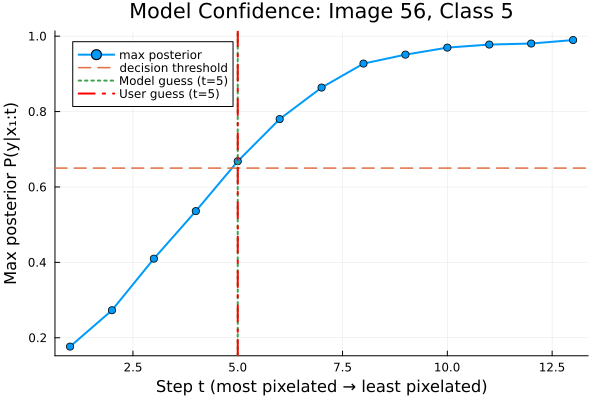


Example Episode Details:
  Image index: 56
  True class: 5
  Model guess: 5 (correct: true)
  User guess: 5 (correct: true)


In [52]:
# Plot example: confidence over time for a specific episode
if length(results) > 0
    # Pick first episode as example
    example = results[1]
    
    p = plot(1:length(example[:max_posteriors]), example[:max_posteriors],
             xlabel="Step t (most pixelated → least pixelated)",
             ylabel="Max posterior P(y|x₁:t)",
             title="Model Confidence: Image $(example[:image_idx]), Class $(example[:class_label])",
             marker=:circle, label="max posterior", linewidth=2)
    
    hline!([0.65], linestyle=:dash, label="decision threshold", linewidth=1.5)
    
    # Mark when model guessed
    if example[:model_guess_t] <= length(example[:max_posteriors])
        vline!([example[:model_guess_t]], linestyle=:dot, label="Model guess (t=$(example[:model_guess_t]))", linewidth=2)
    end
    
    # Mark when user guessed (if available)
    if !ismissing(example[:user_guess_t])
        vline!([example[:user_guess_t]], linestyle=:dashdot, 
               label="User guess (t=$(example[:user_guess_t]))", linewidth=2, color=:red)
    end
    
    display(p)
    
    # Summary statistics
    println("\nExample Episode Details:")
    println("  Image index: $(example[:image_idx])")
    println("  True class: $(example[:class_label])")
    println("  Model guess: $(example[:model_guess]) (correct: $(example[:model_correct]))")
    if !ismissing(example[:user_guess])
        println("  User guess: $(example[:user_guess]) (correct: $(example[:user_correct]))")
    end
end

## 5) Results / demos
Optional demos on a single image and any additional visualization helpers.

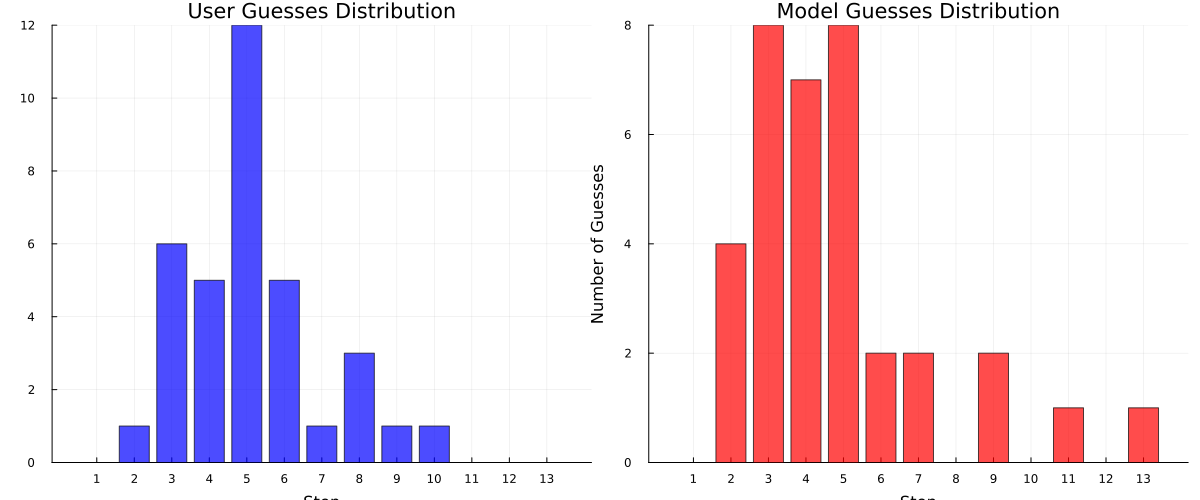

In [73]:
# Visualization: Distribution of guesses by step
if length(results) > 0
    # Calculate accuracy
    model_correct = count(r -> r[:model_correct] === true, results)
    n_user_labeled = count(r -> !ismissing(r[:user_guess]), results)
    user_correct = count(r -> (!ismissing(r[:user_guess]) && r[:user_correct] === true), results)
    model_accuracy = round(model_correct / length(results), digits=3)
    user_accuracy = n_user_labeled > 0 ? round(user_correct / n_user_labeled, digits=3) : 0.0
    
    # Get user and model guess steps
    user_guess_steps = [r[:user_guess_t] for r in results if !ismissing(r[:user_guess_t])]
    model_guess_steps = [r[:model_guess_t] for r in results]
    
    # Find the maximum step
    max_step = max(isempty(user_guess_steps) ? 0 : maximum(user_guess_steps),
                   isempty(model_guess_steps) ? 0 : maximum(model_guess_steps))
    
    if max_step > 0
        # Create histograms
        user_counts = zeros(Int, max_step)
        model_counts = zeros(Int, max_step)
        
        for step in user_guess_steps
            if step <= max_step
                user_counts[step] += 1
            end
        end
        
        for step in model_guess_steps
            if step <= max_step
                model_counts[step] += 1
            end
        end
        
        # Create side-by-side subplots
        steps = 1:max_step
        
        # Calculate max y values for annotation positioning
        max_y_user = isempty(user_counts) ? 1 : maximum(user_counts)
        max_y_model = isempty(model_counts) ? 1 : maximum(model_counts)
        
        # User subplot with annotation
        p1 = bar(steps, user_counts, 
                 label="User", 
                 alpha=0.7, 
                 color=:blue,
                 xlabel="Step",
                 ylabel="Number of Guesses",
                 title="User Guesses Distribution",
                 legend=false,
                 xticks=1:max_step)
        
        user_accuracy_text = "Accuracy: $(user_accuracy)"
        plot!(p1, 
            annotation=(max_step * 0.95, max_y_user * 0.95, 
                       text(user_accuracy_text, :right, 10, :black, :box, :white, 0.5))
        )
        
        # Model subplot with annotation
        p2 = bar(steps, model_counts, 
                 label="Model", 
                 alpha=0.7, 
                 color=:red,
                 xlabel="Step",
                 ylabel="Number of Guesses",
                 title="Model Guesses Distribution",
                 legend=false,
                 xticks=1:max_step)
        
        model_accuracy_text = "Accuracy: $(model_accuracy)"
        plot!(p2, 
            annotation=(max_step * 0.95, max_y_model * 0.95, 
                       text(model_accuracy_text, :right, 10, :black, :box, :white, 0.5))
        )
        
        # Combine into side-by-side layout
        p = plot(p1, p2, layout=(1, 2), size=(1200, 500))
        
        display(p)
    else
        println("No valid guess steps found.")
    end
else
    println("No results available for visualization.")
end

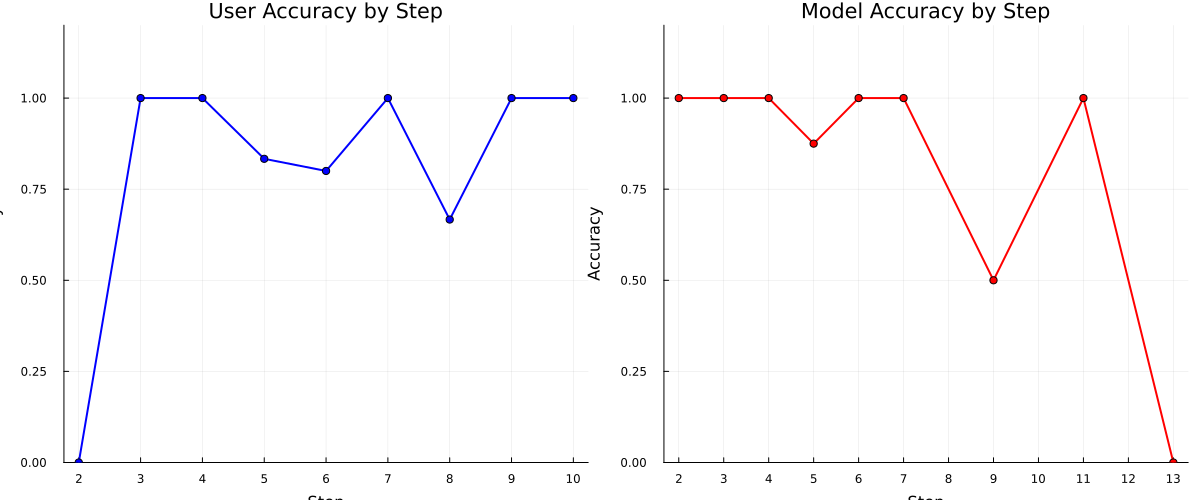

In [78]:
# Visualization: Accuracy as a function of step
if length(results) > 0
    # Get user and model guess steps
    user_guess_steps = [r[:user_guess_t] for r in results if !ismissing(r[:user_guess_t])]
    model_guess_steps = [r[:model_guess_t] for r in results]
    
    # Find the maximum step
    max_step = max(isempty(user_guess_steps) ? 0 : maximum(user_guess_steps),
                   isempty(model_guess_steps) ? 0 : maximum(model_guess_steps))
    
    if max_step > 0
        # Calculate accuracy at each step (only for steps with guesses)
        user_steps_with_data = Int[]
        user_accuracy_by_step = Float64[]
        model_steps_with_data = Int[]
        model_accuracy_by_step = Float64[]
        
        for step in 1:max_step
            # User accuracy at this step
            user_guesses_at_step = [r for r in results if !ismissing(r[:user_guess_t]) && r[:user_guess_t] == step]
            if !isempty(user_guesses_at_step)
                user_correct_at_step = count(r -> r[:user_correct] === true, user_guesses_at_step)
                push!(user_steps_with_data, step)
                push!(user_accuracy_by_step, user_correct_at_step / length(user_guesses_at_step))
            end
            
            # Model accuracy at this step
            model_guesses_at_step = [r for r in results if r[:model_guess_t] == step]
            if !isempty(model_guesses_at_step)
                model_correct_at_step = count(r -> r[:model_correct] === true, model_guesses_at_step)
                push!(model_steps_with_data, step)
                push!(model_accuracy_by_step, model_correct_at_step / length(model_guesses_at_step))
            end
        end
        
        # User accuracy plot
        p1 = plot(user_steps_with_data, user_accuracy_by_step,
                 marker=:circle,
                 linewidth=2,
                 color=:blue,
                 xlabel="Step",
                 ylabel="Accuracy",
                 title="User Accuracy by Step",
                 ylims=(0, 1.2),
                 legend=false,
                 xticks=1:max_step)
        
        # Model accuracy plot
        p2 = plot(model_steps_with_data, model_accuracy_by_step,
                 marker=:circle,
                 linewidth=2,
                 color=:red,
                 xlabel="Step",
                 ylabel="Accuracy",
                 title="Model Accuracy by Step",
                 ylims=(0, 1.2),
                 legend=false,
                 xticks=1:max_step)
        
        # Combine into side-by-side layout
        p = plot(p1, p2, layout=(1, 2), size=(1200, 500))
        
        display(p)
    else
        println("No valid guess steps found.")
    end
else
    println("No results available for visualization.")
end